<a href="https://colab.research.google.com/github/NIKHILCHAUHAN87667/ML_GenerativeAI_projects/blob/main/BitspaceV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Run this first in Colab
!pip install trimesh tqdm torch torchvision scipy

In [3]:
# Imports & config
import os
from pathlib import Path
import numpy as np
import trimesh
import torch
from tqdm import tqdm
import traceback

# CONFIG - edit paths below
INPUT_DIR = "/content/drive/MyDrive/dataset"   # <- put your models here
OUTPUT_DIR = "/content/drive/MyDrive/bitspace_colored_voxels"  # <- where voxel outputs go
VOXEL_RES = 32   # start with 32^3
SAVE_NPY = True  # save individual .npy files
COMBINED_SAVE_PATH = os.path.join(OUTPUT_DIR, "bitspace_voxels.pt")

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("loaded")


loaded


In [4]:
import numpy as np
import trimesh

# --------------------------------------------------------
# 1. Normalize mesh (same as before)
# --------------------------------------------------------
def normalize_mesh(mesh):
    """Center + uniformly scale mesh to unit extents."""
    if mesh is None or mesh.is_empty:
        return None
    try:
        mesh.remove_unreferenced_vertices()
    except Exception:
        pass
    ext = mesh.extents
    max_e = float(ext.max())
    if max_e <= 0 or np.isnan(max_e):
        return None
    # Center the mesh
    try:
        mesh.apply_translation(-mesh.centroid)
    except Exception:
        pass
    # Scale to fit within a cube of side 1.0
    try:
        mesh.apply_scale(1.0 / max_e)
    except Exception:
        return None
    return mesh


# --------------------------------------------------------
# 2. Color-Aware Voxelization
# --------------------------------------------------------
def mesh_to_colored_voxel_matrix(mesh, res=32):
    """
    Convert a colored mesh into a voxel grid with RGB + occupancy channels.
    Output shape: (4, res, res, res)
      [0] = R, [1] = G, [2] = B, [3] = Occupancy
    """
    try:
        # Choose pitch based on mesh extents (~1.0 after normalization)
        pitch = mesh.extents.max() / max(1, (res - 1))
        v = mesh.voxelized(pitch=pitch)

        # Initialize voxel grid (R,G,B,Occupancy)
        voxels = np.zeros((4, res, res, res), dtype=np.float32)
        mat = v.matrix.astype(bool)

        # Resize to fit centered in the output cube
        sx, sy, sz = mat.shape
        ox = (res - sx) // 2
        oy = (res - sy) // 2
        oz = (res - sz) // 2
        ex = min(sx, res - ox)
        ey = min(sy, res - oy)
        ez = min(sz, res - oz)
        voxels[3, ox:ox+ex, oy:oy+ey, oz:oz+ez] = mat[:ex, :ey, :ez]

        # If color data exists, sample colors per voxel
        if hasattr(mesh.visual, 'vertex_colors') and mesh.visual.vertex_colors is not None:
            # Sample many points to approximate voxel color occupancy
            pts, face_idx = trimesh.sample.sample_surface(mesh, res**3)
            colors = mesh.visual.vertex_colors[mesh.faces[face_idx][:, 0], :3] / 255.0
            coords = np.clip((pts * res).astype(int), 0, res - 1)
            for i, (x, y, z) in enumerate(coords):
                voxels[0, x, y, z] = colors[i, 0]
                voxels[1, x, y, z] = colors[i, 1]
                voxels[2, x, y, z] = colors[i, 2]
                voxels[3, x, y, z] = 1.0  # Occupied

        return voxels
    except Exception as e:
        print(f"⚠️ Color voxelization failed: {e}")
        return None


# --------------------------------------------------------
# 3. Robust Mesh Loader (unchanged, with minor fix)
# --------------------------------------------------------
def try_load_mesh(path):
    """Robust mesh loader using trimesh. Returns a single merged mesh or None."""
    try:
        m = trimesh.load(path, force='mesh')
        if isinstance(m, trimesh.Scene):
            # Combine scene geometry into a single mesh
            try:
                meshes = [g for g in m.geometry.values()]
                if len(meshes) == 0:
                    return None
                m = trimesh.util.concatenate(meshes)
            except Exception:
                m = trimesh.util.concatenate(m.dump()) if hasattr(m, 'dump') else None
        return m
    except Exception:
        try:
            return trimesh.load_mesh(path)
        except Exception:
            return None


In [5]:
import os, torch, numpy as np, traceback, gc, time
from tqdm import tqdm
from pathlib import Path
from multiprocessing import Process

INPUT_DIR = "/content/drive/MyDrive/dataset"
OUTPUT_DIR = "/content/drive/MyDrive/bitspace_colored_voxels"
VOXEL_RES = 32

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Resume logic: skip already processed files
all_paths = list(Path(INPUT_DIR).rglob("*.glb")) + list(Path(INPUT_DIR).rglob("*.obj"))
existing = {Path(f).stem for f in Path(OUTPUT_DIR).rglob("*.pt")}
paths = [p for p in all_paths if Path(p).stem not in existing]
print(f"🧭 Found {len(all_paths)} total files. {len(existing)} done, {len(paths)} left.")

def process_single(path):
    """Each mesh runs in its own clean subprocess."""
    import torch, numpy as np, traceback, gc
    try:
        mesh = try_load_mesh(str(path))
        if mesh is None:
            return "load_failed"

        mesh = normalize_mesh(mesh)
        if mesh is None:
            return "normalize_failed"

        vox_rgbo = mesh_to_colored_voxel_matrix(mesh, res=VOXEL_RES)
        if vox_rgbo is None:
            return "voxel_failed"

        name = Path(path).stem
        tensor = torch.from_numpy(vox_rgbo).to(torch.float16)
        torch.save({"voxel_rgbo": tensor, "name": name},
                   os.path.join(OUTPUT_DIR, f"{name}.pt"))

        del mesh, vox_rgbo, tensor
        gc.collect()
        return "ok"

    except Exception as e:
        print(f"⚠️ Error on {path}: {e}")
        traceback.print_exc()
        gc.collect()
        return repr(e)

# --- Run each mesh in isolation ---
skipped = []
for p in tqdm(paths, desc="Voxelizing (crash-proof mode)"):
    proc = Process(target=process_single, args=(p,))
    proc.start()
    proc.join(timeout=300)  # timeout 5 min per mesh
    if proc.exitcode != 0:
        skipped.append((str(p), f"crashed (exit {proc.exitcode})"))
    time.sleep(0.2)  # short pause between runs

print(f"\n✅ All done. Skipped: {len(skipped)}")
if skipped:
    print("Sample skipped:", skipped[:10])


🧭 Found 117 total files. 0 done, 117 left.


Voxelizing (crash-proof mode): 100%|██████████| 117/117 [11:59<00:00,  6.15s/it]


✅ All done. Skipped: 3
Sample skipped: [('/content/drive/MyDrive/dataset/buchanka_snow_glider.glb', 'crashed (exit -9)'), ('/content/drive/MyDrive/dataset/cinema_camera.glb', 'crashed (exit -9)'), ('/content/drive/MyDrive/dataset/sci_fi_box_2.glb', 'crashed (exit -9)')]


In [7]:
import os, torch, numpy as np, gc
from tqdm import tqdm
from pathlib import Path

INPUT_DIR = "/content/drive/MyDrive/bitspace_colored_voxels"
OUTPUT_DIR = "/content/drive/MyDrive/bitspace_colored_voxels_augmented"
os.makedirs(OUTPUT_DIR, exist_ok=True)

AUG_PER_FILE = 5  # number of augmented samples per file

def augment_voxel(vox):
    """Apply random 3D transformations and color jitter."""
    vox = vox.clone()

    # --- Random 90° rotation along a valid pair of spatial axes ---
    k = np.random.randint(0, 4)
    axes = [(1, 2), (1, 3), (2, 3)]
    rot_axes = axes[np.random.randint(0, len(axes))]
    vox = torch.rot90(vox, k=k, dims=rot_axes)

    # --- Random flips along valid spatial axes ---
    if np.random.rand() > 0.5:
        flip_axis = np.random.choice([1, 2, 3])
        vox = torch.flip(vox, dims=[flip_axis])

    # --- Random Gaussian noise (only color channels) ---
    noise = torch.randn_like(vox[:3]) * 0.05
    vox[:3] = torch.clamp(vox[:3] + noise, 0, 1)

    # --- Random color jitter (slight brightness/contrast) ---
    if np.random.rand() > 0.5:
        scale = 0.8 + np.random.rand() * 0.4  # 0.8–1.2
        vox[:3] = torch.clamp(vox[:3] * scale, 0, 1)

    # --- Random voxel dropout (simulate missing geometry) ---
    if np.random.rand() > 0.5:
        mask = (torch.rand_like(vox[3]) > 0.05).float()
        vox[:3] *= mask
        vox[3] *= mask

    return vox

# === Augmentation Loop ===
files = list(Path(INPUT_DIR).rglob("*.pt"))
print(f"Found {len(files)} voxel files to augment.")

for f in tqdm(files, desc="Augmenting voxels"):
    try:
        data = torch.load(f)
        vox = data["voxel_rgbo"]
        name = data["name"]

        for i in range(AUG_PER_FILE):
            aug_vox = augment_voxel(vox)
            aug_name = f"{name}_aug_{i+1}.pt"
            torch.save({"voxel_rgbo": aug_vox.half(), "name": aug_name}, os.path.join(OUTPUT_DIR, aug_name))

        del vox, data, aug_vox
        gc.collect()

    except Exception as e:
        print(f"⚠️ Error on {f}: {e}")
        gc.collect()

print(f"\n✅ Augmentation complete! Saved {AUG_PER_FILE * len(files)} files in {OUTPUT_DIR}")


Found 106 voxel files to augment.


Augmenting voxels: 100%|██████████| 106/106 [00:21<00:00,  5.04it/s]


✅ Augmentation complete! Saved 530 files in /content/drive/MyDrive/bitspace_colored_voxels_augmented


In [9]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm import tqdm
import gc

# --- Config ---
DATA_DIR = "/content/drive/MyDrive/bitspace_colored_voxels_augmented"
BATCH_SIZE = 8
EPOCHS = 60
LR = 1e-3
LATENT_DIM = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)


# === Dataset Loader ===
class VoxelColorDataset(Dataset):
    def __init__(self, folder):
        self.files = list(Path(folder).rglob("*.pt"))
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        vox = data["voxel_rgbo"]  # shape (4, D, D, D)
        return vox

train_dataset = VoxelColorDataset(DATA_DIR)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f"📦 Loaded {len(train_dataset)} augmented voxel samples.")


# === 3D U-Net Autoencoder ===
class UNet3DAutoencoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        # --- Encoder ---
        self.enc1 = nn.Sequential(nn.Conv3d(4, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv3d(32, 64, 3, stride=2, padding=1), nn.BatchNorm3d(64), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv3d(64, 128, 3, stride=2, padding=1), nn.BatchNorm3d(128), nn.ReLU())
        self.enc4 = nn.Sequential(nn.Conv3d(128, 256, 3, stride=2, padding=1), nn.BatchNorm3d(256), nn.ReLU())

        # Bottleneck
        self.fc1 = nn.Linear(256 * 4 * 4 * 4, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 256 * 4 * 4 * 4)

        # --- Decoder ---
        self.dec4 = nn.Sequential(nn.ConvTranspose3d(256, 128, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm3d(128), nn.ReLU())
        self.dec3 = nn.Sequential(nn.ConvTranspose3d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm3d(64), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose3d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm3d(32), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv3d(32, 4, 3, padding=1), nn.Sigmoid())

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        latent = self.fc1(e4.flatten(1))
        x = self.fc2(latent).view(-1, 256, 4, 4, 4)
        d4 = self.dec4(x) + e3
        d3 = self.dec3(d4) + e2
        d2 = self.dec2(d3) + e1
        out = self.dec1(d2)
        return out, latent


# === Loss & Optimizer ===
model = UNet3DAutoencoder(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def hybrid_loss(recon, target):
    """Combine MSE + small BCE for better voxel sharpness."""
    mse = F.mse_loss(recon, target)
    bce = F.binary_cross_entropy(recon[:, 3:], target[:, 3:])  # only on occupancy channel
    return mse + 0.1 * bce


# === Training Loop ===
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for vox in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        vox = vox.to(DEVICE).float()
        optimizer.zero_grad()
        recon, _ = model(vox)
        loss = hybrid_loss(recon, vox)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        del vox, recon
        gc.collect()
    avg_loss = total_loss / len(train_loader)
    print(f"🧩 Epoch {epoch}/{EPOCHS} — Loss: {avg_loss:.6f}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/bitspace_color_unet_epoch{epoch}.pth")
        print(f"💾 Saved model checkpoint at epoch {epoch}")

print("✅ Training complete!")
torch.save(model.state_dict(), "/content/drive/MyDrive/bitspace_color_unet_final.pth")


🧠 Using device: cuda
📦 Loaded 530 augmented voxel samples.


Epoch 1/60: 100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


🧩 Epoch 1/60 — Loss: 0.023915


Epoch 2/60: 100%|██████████| 67/67 [00:16<00:00,  3.97it/s]


🧩 Epoch 2/60 — Loss: 0.001922


Epoch 3/60: 100%|██████████| 67/67 [00:16<00:00,  4.14it/s]


🧩 Epoch 3/60 — Loss: 0.001374


Epoch 4/60: 100%|██████████| 67/67 [00:17<00:00,  3.79it/s]


🧩 Epoch 4/60 — Loss: 0.001155


Epoch 5/60: 100%|██████████| 67/67 [00:17<00:00,  3.88it/s]


🧩 Epoch 5/60 — Loss: 0.001026


Epoch 6/60: 100%|██████████| 67/67 [00:16<00:00,  3.97it/s]


🧩 Epoch 6/60 — Loss: 0.000937


Epoch 7/60: 100%|██████████| 67/67 [00:16<00:00,  4.03it/s]


🧩 Epoch 7/60 — Loss: 0.000859


Epoch 8/60: 100%|██████████| 67/67 [00:17<00:00,  3.84it/s]


🧩 Epoch 8/60 — Loss: 0.000791


Epoch 9/60: 100%|██████████| 67/67 [00:16<00:00,  4.03it/s]


🧩 Epoch 9/60 — Loss: 0.000740


Epoch 10/60: 100%|██████████| 67/67 [00:16<00:00,  4.00it/s]


🧩 Epoch 10/60 — Loss: 0.000663
💾 Saved model checkpoint at epoch 10


Epoch 11/60: 100%|██████████| 67/67 [00:16<00:00,  3.95it/s]


🧩 Epoch 11/60 — Loss: 0.000574


Epoch 12/60: 100%|██████████| 67/67 [00:17<00:00,  3.82it/s]


🧩 Epoch 12/60 — Loss: 0.000487


Epoch 13/60: 100%|██████████| 67/67 [00:16<00:00,  4.10it/s]


🧩 Epoch 13/60 — Loss: 0.000406


Epoch 14/60: 100%|██████████| 67/67 [00:16<00:00,  4.00it/s]


🧩 Epoch 14/60 — Loss: 0.000349


Epoch 15/60: 100%|██████████| 67/67 [00:16<00:00,  3.99it/s]


🧩 Epoch 15/60 — Loss: 0.000307


Epoch 16/60: 100%|██████████| 67/67 [00:16<00:00,  3.98it/s]


🧩 Epoch 16/60 — Loss: 0.000279


Epoch 17/60: 100%|██████████| 67/67 [00:16<00:00,  4.08it/s]


🧩 Epoch 17/60 — Loss: 0.000255


Epoch 18/60: 100%|██████████| 67/67 [00:16<00:00,  4.03it/s]


🧩 Epoch 18/60 — Loss: 0.000234


Epoch 19/60: 100%|██████████| 67/67 [00:17<00:00,  3.94it/s]


🧩 Epoch 19/60 — Loss: 0.000222


Epoch 20/60: 100%|██████████| 67/67 [00:16<00:00,  4.00it/s]


🧩 Epoch 20/60 — Loss: 0.000209
💾 Saved model checkpoint at epoch 20


Epoch 21/60: 100%|██████████| 67/67 [00:16<00:00,  4.11it/s]


🧩 Epoch 21/60 — Loss: 0.000201


Epoch 22/60: 100%|██████████| 67/67 [00:17<00:00,  3.94it/s]


🧩 Epoch 22/60 — Loss: 0.000192


Epoch 23/60: 100%|██████████| 67/67 [00:17<00:00,  3.87it/s]


🧩 Epoch 23/60 — Loss: 0.000188


Epoch 24/60: 100%|██████████| 67/67 [00:17<00:00,  3.90it/s]


🧩 Epoch 24/60 — Loss: 0.000180


Epoch 25/60: 100%|██████████| 67/67 [00:16<00:00,  3.98it/s]


🧩 Epoch 25/60 — Loss: 0.000172


Epoch 26/60: 100%|██████████| 67/67 [00:17<00:00,  3.78it/s]


🧩 Epoch 26/60 — Loss: 0.000168


Epoch 27/60: 100%|██████████| 67/67 [00:17<00:00,  3.87it/s]


🧩 Epoch 27/60 — Loss: 0.000164


Epoch 28/60: 100%|██████████| 67/67 [00:17<00:00,  3.83it/s]


🧩 Epoch 28/60 — Loss: 0.000159


Epoch 29/60: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]


🧩 Epoch 29/60 — Loss: 0.000158


Epoch 30/60: 100%|██████████| 67/67 [00:17<00:00,  3.76it/s]


🧩 Epoch 30/60 — Loss: 0.000154
💾 Saved model checkpoint at epoch 30


Epoch 31/60: 100%|██████████| 67/67 [00:17<00:00,  3.87it/s]


🧩 Epoch 31/60 — Loss: 0.000149


Epoch 32/60: 100%|██████████| 67/67 [00:18<00:00,  3.67it/s]


🧩 Epoch 32/60 — Loss: 0.000145


Epoch 33/60: 100%|██████████| 67/67 [00:17<00:00,  3.87it/s]


🧩 Epoch 33/60 — Loss: 0.000142


Epoch 34/60: 100%|██████████| 67/67 [00:17<00:00,  3.83it/s]


🧩 Epoch 34/60 — Loss: 0.000138


Epoch 35/60: 100%|██████████| 67/67 [00:17<00:00,  3.76it/s]


🧩 Epoch 35/60 — Loss: 0.000139


Epoch 36/60: 100%|██████████| 67/67 [00:17<00:00,  3.78it/s]


🧩 Epoch 36/60 — Loss: 0.000136


Epoch 37/60: 100%|██████████| 67/67 [00:17<00:00,  3.86it/s]


🧩 Epoch 37/60 — Loss: 0.000131


Epoch 38/60: 100%|██████████| 67/67 [00:18<00:00,  3.68it/s]


🧩 Epoch 38/60 — Loss: 0.000128


Epoch 39/60: 100%|██████████| 67/67 [00:17<00:00,  3.81it/s]


🧩 Epoch 39/60 — Loss: 0.000126


Epoch 40/60: 100%|██████████| 67/67 [00:18<00:00,  3.71it/s]


🧩 Epoch 40/60 — Loss: 0.000122
💾 Saved model checkpoint at epoch 40


Epoch 41/60: 100%|██████████| 67/67 [00:18<00:00,  3.72it/s]


🧩 Epoch 41/60 — Loss: 0.000120


Epoch 42/60: 100%|██████████| 67/67 [00:18<00:00,  3.66it/s]


🧩 Epoch 42/60 — Loss: 0.000118


Epoch 43/60: 100%|██████████| 67/67 [00:18<00:00,  3.71it/s]


🧩 Epoch 43/60 — Loss: 0.000117


Epoch 44/60: 100%|██████████| 67/67 [00:18<00:00,  3.65it/s]


🧩 Epoch 44/60 — Loss: 0.000112


Epoch 45/60: 100%|██████████| 67/67 [00:17<00:00,  3.74it/s]


🧩 Epoch 45/60 — Loss: 0.000111


Epoch 46/60: 100%|██████████| 67/67 [00:18<00:00,  3.58it/s]


🧩 Epoch 46/60 — Loss: 0.000107


Epoch 47/60: 100%|██████████| 67/67 [00:17<00:00,  3.73it/s]


🧩 Epoch 47/60 — Loss: 0.000104


Epoch 48/60: 100%|██████████| 67/67 [00:18<00:00,  3.64it/s]


🧩 Epoch 48/60 — Loss: 0.000102


Epoch 49/60: 100%|██████████| 67/67 [00:18<00:00,  3.63it/s]


🧩 Epoch 49/60 — Loss: 0.000099


Epoch 50/60: 100%|██████████| 67/67 [00:18<00:00,  3.66it/s]


🧩 Epoch 50/60 — Loss: 0.000099
💾 Saved model checkpoint at epoch 50


Epoch 51/60: 100%|██████████| 67/67 [00:18<00:00,  3.67it/s]


🧩 Epoch 51/60 — Loss: 0.000096


Epoch 52/60: 100%|██████████| 67/67 [00:18<00:00,  3.66it/s]


🧩 Epoch 52/60 — Loss: 0.000091


Epoch 53/60: 100%|██████████| 67/67 [00:17<00:00,  3.79it/s]


🧩 Epoch 53/60 — Loss: 0.000091


Epoch 54/60: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]


🧩 Epoch 54/60 — Loss: 0.000087


Epoch 55/60: 100%|██████████| 67/67 [00:17<00:00,  3.72it/s]


🧩 Epoch 55/60 — Loss: 0.000084


Epoch 56/60: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]


🧩 Epoch 56/60 — Loss: 0.000082


Epoch 57/60: 100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


🧩 Epoch 57/60 — Loss: 0.000081


Epoch 58/60: 100%|██████████| 67/67 [00:17<00:00,  3.74it/s]


🧩 Epoch 58/60 — Loss: 0.000077


Epoch 59/60: 100%|██████████| 67/67 [00:18<00:00,  3.71it/s]


🧩 Epoch 59/60 — Loss: 0.000074


Epoch 60/60: 100%|██████████| 67/67 [00:17<00:00,  3.78it/s]


🧩 Epoch 60/60 — Loss: 0.000073
💾 Saved model checkpoint at epoch 60
✅ Training complete!


✅ Model loaded successfully
🎨 Visualizing traffic_signal_control_cabinet_uh4ffdmga_raw_aug_5.pt


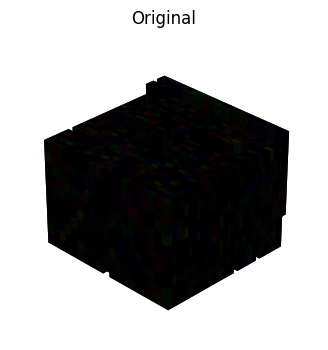

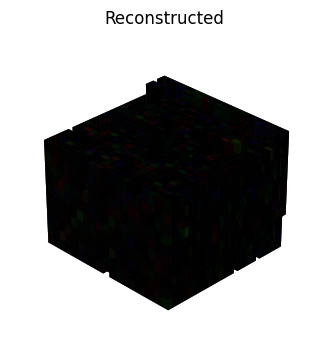

🎨 Visualizing 12_aug_2.pt


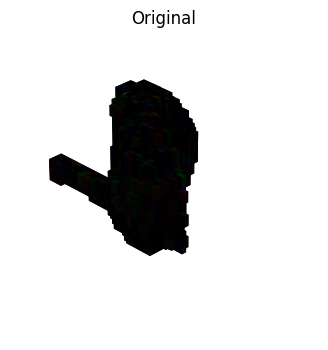

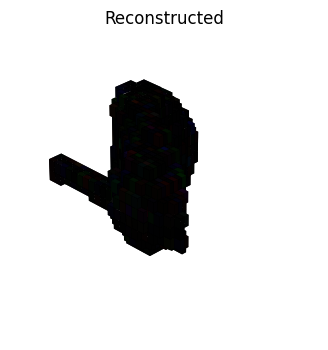

🎨 Visualizing mo_grand_piano_mo_35_aug_5.pt


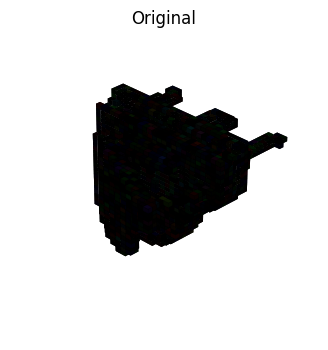

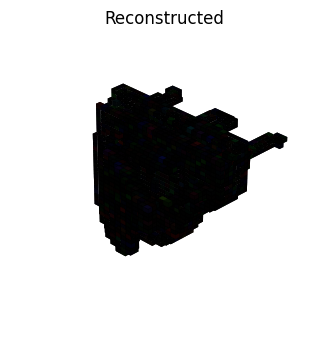

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from pathlib import Path
import gc

# === Config ===
MODEL_PATH = "/content/drive/MyDrive/bitspace_color_unet_final.pth"
DATA_DIR = "/content/drive/MyDrive/bitspace_colored_voxels_augmented"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Reload model ===
model = UNet3DAutoencoder(latent_dim=512).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ Model loaded successfully")

# === Helper to visualize a voxel grid ===
def plot_voxel(voxel, title="", threshold=0.3):
    voxel = voxel.detach().cpu().numpy()
    occ = voxel[3] > threshold
    colors = np.moveaxis(voxel[:3], 0, -1)
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(occ, facecolors=colors, edgecolor='k', linewidth=0.05)
    ax.set_title(title)
    ax.view_init(30, 45)
    plt.axis('off')
    plt.show()

# === Pick random samples and reconstruct ===
files = list(Path(DATA_DIR).rglob("*.pt"))
random.shuffle(files)

for f in files[:3]:  # visualize 3 samples
    data = torch.load(f)
    vox = data["voxel_rgbo"].unsqueeze(0).to(DEVICE).float()
    with torch.no_grad():
        recon, latent = model(vox)
    print(f"🎨 Visualizing {data['name']}")

    plot_voxel(vox[0], "Original")
    plot_voxel(recon[0], "Reconstructed")

    del vox, recon, latent
    gc.collect()
